# I - Phonon structure of different solids

In [ ]:
!pip install mp-api
!pip install mpcontribs-client
!pip install crystal-toolkit --upgrade
!pip install dash


In [2]:
!pip install --upgrade jupyterlab nglview
!jupyter nbextension install --py --overwrite --sys-prefix nglview
!jupyter nbextension enable --py --sys-prefix nglview
!jupyter labextension install nglview-js-widgets@latest

  Using cached jupyterlab-4.1.2-py3-none-any.whl.metadata (15 kB)
Using cached jupyterlab-4.1.2-py3-none-any.whl (11.4 MB)
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.0.6
    Uninstalling jupyterlab-4.0.6:
      Successfully uninstalled jupyterlab-4.0.6


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: contrib dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert nbextensions_configurator notebook run
script server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--d

http://henriquemiranda.github.io/phononwebsite/phonon.html?rest=https://materialsproject.org/rest/v2/materials/mp-66/phononbs&name=C&link=https://materialsproject.org/materials/mp-66&hidematlist=true

# Play with 1507 compounds

In [1]:
from ipywidgets import interact, Dropdown
import numpy as np
from pymatgen.io.cif import CifWriter
import nglview as nv
import pandas as pd
from pymatgen.ext.matproj import MPRester
from mp_api.client import MPRester
from pylab import *
import pandas as pd
from emmet.core.summary import HasProps
from nglview import show_structure_file
from pymatgen.io.cif import CifWriter


C:\Users\roste\AppData\Local\Temp\ipykernel_3852\3769355885.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\roste\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


No module named 'phonopy'
No module named 'phonopy'


In [3]:

API_key= "A55hSVu7NuwvlISilTvVtw37IB5ES26w"

plt.rcParams.update({'font.size': 14})
with MPRester(API_key) as mpr:
    docs = mpr.summary.search(
        has_props = [HasProps.phonon], fields=["material_id", "formula_pretty","elements", "composition"]
    )
    mpids = [doc.material_id for doc in docs]
    mpformulas = [doc.formula_pretty for doc in docs]
    mpcomposition = [doc.composition for doc in docs]
    

data = {"mp ID": mpids, "Formula": mpformulas}
df_data = pd.DataFrame(data)

d_look_up      = { mpformulas[i]:mpids[i] for i in range(len(mpformulas))}
d_look_up_comp = { mpformulas[i]:mpcomposition[i] for i in range(len(mpformulas))}

# Interactive function
@interact(material=Dropdown(options=sort(df_data["Formula"]), description="Materials available"))
def plot_phonon_and_structure(material):
    material_id = d_look_up[material][:]
    mat_comp    = d_look_up_comp[material]
    print("The ID of the material is: ", material_id)
    print("The composition of the material is: ", mat_comp)
    with MPRester(API_key) as mpr:
        ph_bs = mpr.get_phonon_bandstructure_by_material_id(material_id)
        ph_dos = mpr.get_phonon_dos_by_material_id(material_id)
        structure = mpr.get_structure_by_material_id(material_id)

    position = []
    label = []
    lines = []

    for i in ph_bs.as_phononwebsite()["line_breaks"]:
        lines.append(i[0])

    for i in ph_bs.as_phononwebsite()["highsym_qpts"]:
        position.append(i[0])
        label.append("$" + i[1] + "$")

    print(structure)
    cif_filename = f"material_structure_{material_id}.cif"  # Name of the output CIF file

    cif_writer = CifWriter(structure)
    cif_writer.write_file(cif_filename)
    struct_file = nv.FileStructure(cif_filename)
    
    view = nv.show_file(struct_file)
    view._remote_call("setSize", args=["", "300px"])
    view.camera = "orthographic"
    view.add_unitcell()
    view

    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 7), gridspec_kw={'wspace': 0.2, 'hspace': 0, 'width_ratios': [2, 1]})
    ax[0].plot(ph_bs.as_phononwebsite()["eigenvalues"])
    density_points = len(ph_dos.as_dict()["densities"])
    ax[0].set_ylim(0, (density_points))
    ax[0].set_xlim(0, max(position))
    ax[0].set_xticks(position, label)
    ax[0].set_ylabel(r"Frequency [$cm^{-1}$]")
    ax[0].set_xlabel(r"K  [$\frac{2\pi}{a}$]")
    ax[1].set_xlabel(r"DOS")
    for i in lines:
        ax[0].axvline(i - 1, c="black")

    ax[1].plot(ph_dos.as_dict()["densities"], np.arange(density_points))
    ax[1].set_ylim(0, (density_points))
    ax[1].set_xlim(0)

    
    ph_ws_filename = "ph_ws_material_structure_{0}_{1}.json".format(material_id,material)
    ph_bs.write_phononwebsite(ph_ws_filename)
    return view

Retrieving SummaryDoc documents:   0%|          | 0/1512 [00:00<?, ?it/s]

interactive(children=(Dropdown(description='Materials available', options=('Ag2GeS3', 'Ag2HgI4', 'Ag2HgI4', 'A…

# IR and raman

In [2]:

material_id = "mp-2657"
API_key= "A55hSVu7NuwvlISilTvVtw37IB5ES26w"

# with MPRester(API_key) as mpr:
#     docs = mpr.summary.search(
#         has_props = [HasProps.phonon], fields=["material_id", "formula_pretty","elements", "composition"]
#     )
#     mpids = [doc.material_id for doc in docs]
#     mpformulas = [doc.formula_pretty for doc in docs]
#     mpcomposition = [doc.composition for doc in docs]
# data = {"mp ID": mpids, "Formula": mpformulas }
# df_data = pd.DataFrame(data)
# df_data


with MPRester(API_key) as mpr:
    ph_bs     = mpr.get_phonon_bandstructure_by_material_id(material_id)
    ph_bs_r     = mpr.get_phonon_bandstructure_by_material_id(material_id)
    ph_dos    = mpr.get_phonon_dos_by_material_id(material_id)
    structure = mpr.get_structure_by_material_id(material_id)


print(ph_bs.band_reorder())
print(structure)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

None
Full Formula (Ti4 O8)
Reduced Formula: TiO2
abc   :   5.469502   5.469505   5.469505
angles: 114.491261 107.018456 107.023725
pbc   :       True       True       True
Sites (12)
  #  SP            a         b          c    magmom
---  ----  ---------  --------  ---------  --------
  0  Ti     0.499998  0.749993   0.749996        -0
  1  Ti     0.500003  0.250004   0.250002        -0
  2  Ti    -0         1e-06      0.500001         0
  3  Ti    -1e-06     0.500002   2e-06            0
  4  O      0.304321  0.304625   0.500303         0
  5  O      0.195242  0.249581   0.945661        -0
  6  O      0.304321  0.804018  -0.000303         0
  7  O      0.80392   0.249581   0.554339         0
  8  O      0.19608   0.750418   0.44566          0
  9  O      0.804758  0.750417   0.054338        -0
 10  O      0.69568   0.195983   0.000304        -0
 11  O      0.695679  0.695375   0.499698         0


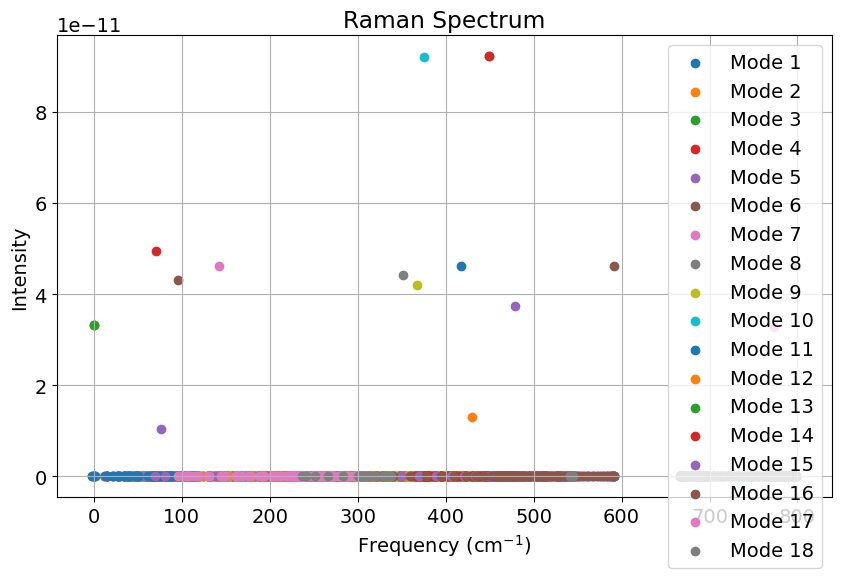

In [3]:
import numpy as np

bands, qpoints, basis, vector = shape(ph_bs.eigendisplacements)
# Sample eigenvectors and eigenvalues (replace with your actual data)

eigenvectors = ph_bs.eigendisplacements
eigenvalues  = ph_bs.bands
qpoints_v = ph_bs.as_dict()["qpoints"]



# Constants (you might need to adjust these)
proportionality_IR = 1.0
proportionality_Raman = 1.0

# Calculate IR intensities
IR_intensities = np.zeros((bands, qpoints))
for i in range(bands):
    for q in range(qpoints):
        for basis_dir in range(basis):
            IR_intensities[i, q] += np.abs(np.dot(
                eigenvectors[i, q, basis_dir],
                qpoints_v[q])  # Replace with actual Cartesian direction vector
            ) ** 2

# Calculate Raman intensities
Raman_intensities = np.zeros((bands, qpoints))
for i in range(bands):
    # for q in range(qpoints):
    for basis_dir_alpha in range(basis):
        for basis_dir_beta in range(basis):
            Raman_intensities[i, 0] += np.abs(np.dot(
                        eigenvectors[i, 0, basis_dir_alpha],
                        eigenvectors[i, 0, basis_dir_beta]
                    )) ** 2 * proportionality_Raman

# Normalize intensities
IR_intensities *= proportionality_IR
Raman_intensities *= proportionality_Raman

# Now you can plot the IR and Raman spectra using your preferred plotting library
# (e.g., Matplotlib)
# Plot Raman Spectrum
plt.figure(figsize=(10, 6))
frequencies=eigenvalues
IR_total= list(zeros(len(frequencies[0])))
Freq_total= list(zeros(len(frequencies[0])))
for i in range(bands):
    plt.scatter(frequencies[i]*33.356, Raman_intensities[i], label=f'Mode {i+1}')
    IR_total+=list(Raman_intensities[i])
    Freq_total+=list(frequencies[i]*33.356)

plt.xlabel('Frequency (cm$^{-1}$)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum')
plt.legend()
plt.grid()
plt.show()

Freq_0 = list(arange(0,2000,0.1))
IR_0   = list(zeros(len(Freq_0)))

Freq_total_s = Freq_0 + Freq_total
IR_total_s   = IR_0 + IR_total
all= []
for i in range(len(IR_total_s)):
    all.append(tuple((Freq_total_s[i],IR_total_s[i])))

all.sort()
x= []
y= []
for i in all:
    x.append(round(i[0],1))
    y.append(i[1])
    

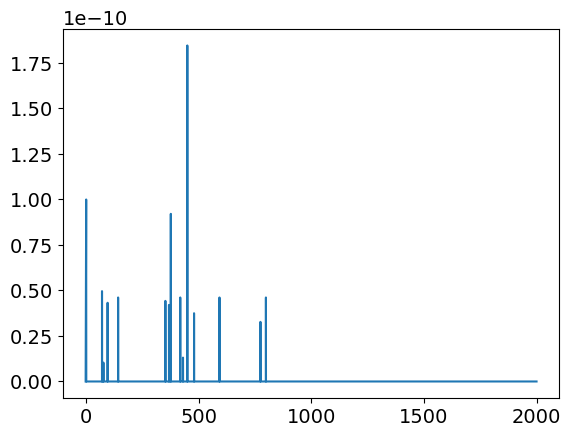

In [11]:
frequencies = x 
intensities = y 


# Crear un diccionario para realizar un seguimiento de las sumas de intensidades por frecuencia
frequency_intensity_dict = {}


for frequency, intensity in zip(frequencies, intensities):

    if frequency in frequency_intensity_dict:
        frequency_intensity_dict[frequency] += intensity
    else:
       
        frequency_intensity_dict[frequency] = intensity

result_frequencies = list(frequency_intensity_dict.keys())
result_intensities = list(frequency_intensity_dict.values())
plot(result_frequencies,result_intensities)


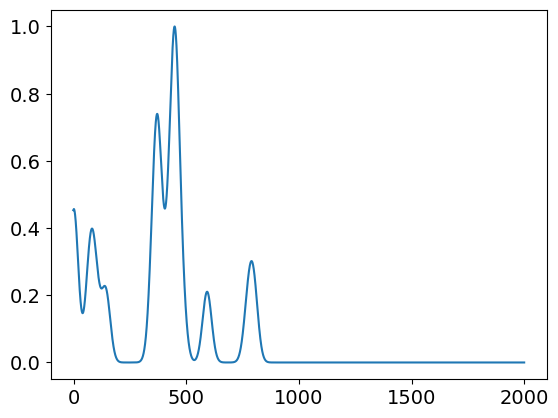

In [12]:
from scipy.signal import argrelextrema
def g(wavenumb_sweep, intensity_max, wavenumber_max, σ):
    G = intensity_max / (σ *sqrt(2 * pi)) * exp(-(wavenumb_sweep-wavenumber_max)**2 / (2*σ**2))
    new_y=array(G)  
    return new_y
result_frequencies = list(frequency_intensity_dict.keys())
result_intensities = list(frequency_intensity_dict.values())      

wavenumb   = result_frequencies
max_int    = max(result_intensities)

norm_int = []
for i in result_intensities:
    norm_int.append(i/max_int)

### Gausian function to broaden peaks
pos_max    = argrelextrema(array(norm_int), np.greater)
x          = array(wavenumb)
all_curve = 0
σ = 20
for i in pos_max[0]:
    all_curve += g(x, norm_int[i], wavenumb[i],σ)      
broad_int = all_curve   

### Normalization

max_y = max(broad_int)
int_norm = []

for i in broad_int:
    int_norm.append((i/max_y))
plot(wavenumb,int_norm)

